PCA instead of feature selection
single model od adhda and sex f remove and use multiple
remove garphs and just classification report


In [25]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


In [26]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

In [27]:
target = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAINING_SOLUTIONS.xlsx')
categorical = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_CATEGORICAL_METADATA.xlsx')
function = pd.read_csv(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
quantitative = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_QUANTITATIVE_METADATA.xlsx')

target.shape, categorical.shape, function.shape,quantitative.shape
len(target['participant_id'].unique()),\
len(categorical['participant_id'].unique()),\
len(function['participant_id'].unique()),\
len(quantitative['participant_id'].unique())

(1213, 1213, 1213, 1213)

In [28]:
def get_feats(mode='TRAIN'):
    # Define base dataset path
    base_path = r'C:\Users\abdur\vs_code\sidra\widsdatathon2025'
    mode_path = os.path.join(base_path, mode)
    
    # Load quantitative metadata
    feats = pd.read_excel(os.path.join(mode_path, f'{mode}_QUANTITATIVE_METADATA.xlsx'), engine='openpyxl')
    
    # Load categorical metadata with correct filename depending on mode
    if mode == 'TRAIN':
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL_METADATA.xlsx')
    else:
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL.xlsx')
    
    cate = pd.read_excel(cate_path, engine='openpyxl')
    
    # Merge categorical data
    feats = feats.merge(cate, on='participant_id', how='left')
    
    # Load functional connectome matrices
    func = pd.read_csv(os.path.join(mode_path, f'{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv'))
    feats = feats.merge(func, on='participant_id', how='left')
    
    # If training data, merge with solution file
    if mode == 'TRAIN':
        solution_path = os.path.join(mode_path, 'TRAINING_SOLUTIONS.xlsx')
        solution = pd.read_excel(solution_path, engine='openpyxl')
        feats = feats.merge(solution, on='participant_id', how='left')
    
    return feats
# Load the combined dataset for training
df_train = get_feats('TRAIN')
print("Final dataset shape:", df_train.shape)

Final dataset shape: (1213, 19930)


In [29]:
train_df = get_feats(mode='TRAIN')
test_df = get_feats(mode='TEST')
print (train_df.shape, test_df.shape)
# Display the first few rows of the training data
train_df.head()

(1213, 19930) (304, 19928)


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,...,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984,1,1
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,...,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381,1,0
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,...,0.010771,-0.044341,0.128386,0.047282,0.087678,0.146221,-0.009425,0.035150,1,0
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,...,-0.007152,0.032584,0.121726,0.045089,0.154464,0.106817,0.065336,0.234708,1,1
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,...,-0.010196,0.035638,0.074978,0.030579,0.025640,0.118199,0.112522,0.143666,1,1


In [30]:
test_df.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823


In [31]:
# Drop 'participant_id' column
train_df = train_df.drop(columns=['participant_id'])

In [32]:

# Get data types of all columns
print("Data types of columns:")
print(train_df.dtypes)

Data types of columns:
EHQ_EHQ_Total           float64
ColorVision_CV_Score      int64
APQ_P_APQ_P_CP            int64
APQ_P_APQ_P_ID            int64
APQ_P_APQ_P_INV           int64
                         ...   
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
ADHD_Outcome              int64
Sex_F                     int64
Length: 19929, dtype: object


In [33]:
# Take the first 50 rows of train_df
train_df_50 = train_df

In [34]:
# Check for missing values
print("Missing values in each column:")
print(train_df_50.isnull().sum())


Missing values in each column:
EHQ_EHQ_Total           0
ColorVision_CV_Score    0
APQ_P_APQ_P_CP          0
APQ_P_APQ_P_ID          0
APQ_P_APQ_P_INV         0
                       ..
197throw_198thcolumn    0
197throw_199thcolumn    0
198throw_199thcolumn    0
ADHD_Outcome            0
Sex_F                   0
Length: 19929, dtype: int64


In [35]:
# Load Data (Ensure train_df_50 is already loaded before running this code)
# Extract labels if they are part of train_df_50
if 'labels' not in globals():
    labels = train_df_50[["ADHD_Outcome", "Sex_F"]].copy()  # Extract labels from train_df_50

# 1. Drop columns
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_df_50 = train_df_50.drop(columns=drop_cols, errors='ignore')  # Avoid errors if column missing

# 2. Remove non-numeric columns before scaling
numeric_cols = train_df_50.select_dtypes(include=[np.number]).columns  # Keep only numeric columns
train_df_50 = train_df_50[numeric_cols]  # Drop categorical or object columns

# 3. Normalize features using MinMaxScaler
scaler = MinMaxScaler()
train_df_50.iloc[:, :] = scaler.fit_transform(train_df_50)


# 5. Retrieve target variables
y_adhd = labels["ADHD_Outcome"].copy()
y_sex = labels["Sex_F"].copy()



In [36]:
print(train_df_50["ADHD_Outcome"].unique())
print(train_df_50["Sex_F"].unique())
print(train_df_50["ADHD_Outcome"].value_counts())
print(train_df_50["Sex_F"].value_counts())

[1 0]
[1 0]
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64
Sex_F
0    797
1    416
Name: count, dtype: int64


In [37]:
print(train_df_50['ADHD_Outcome'].value_counts(normalize=True))  
print(test_df['ADHD_Outcome'].value_counts(normalize=True))  

ADHD_Outcome
1    0.685078
0    0.314922
Name: proportion, dtype: float64


KeyError: 'ADHD_Outcome'

Using the filtered features dataset for training.
Training data shape: (1213, 17)
Using provided test dataset parameter.
Test data shape: (304, 19928)
Original number of features: 15

Training data NaN values: 0
Test data NaN values: 285

Preprocessing data with NaN handling...
Identified 10 behavioral features:
SDQ_SDQ_Hyperactivity, SDQ_SDQ_Externalizing, SDQ_SDQ_Difficulties_Total, SDQ_SDQ_Generating_Impact, SDQ_SDQ_Conduct_Problems, SDQ_SDQ_Internalizing, SDQ_SDQ_Emotional_Problems, SDQ_SDQ_Prosocial, SDQ_SDQ_Peer_Problems, APQ_P_APQ_P_OPD
Created 45 interaction terms between behavioral features
Created 45 interaction terms between behavioral features

Performing feature selection on interaction features...
Selecting features for ADHD_Outcome...
Selecting features for Sex_F...
Selected 12 features for ADHD_Outcome (7 interactions)
Selected 18 features for Sex_F (14 interactions)

Applying SMOTE-ENN for balanced sampling...
Balancing ADHD_Outcome data...
Balancing Sex_F data...
Orig

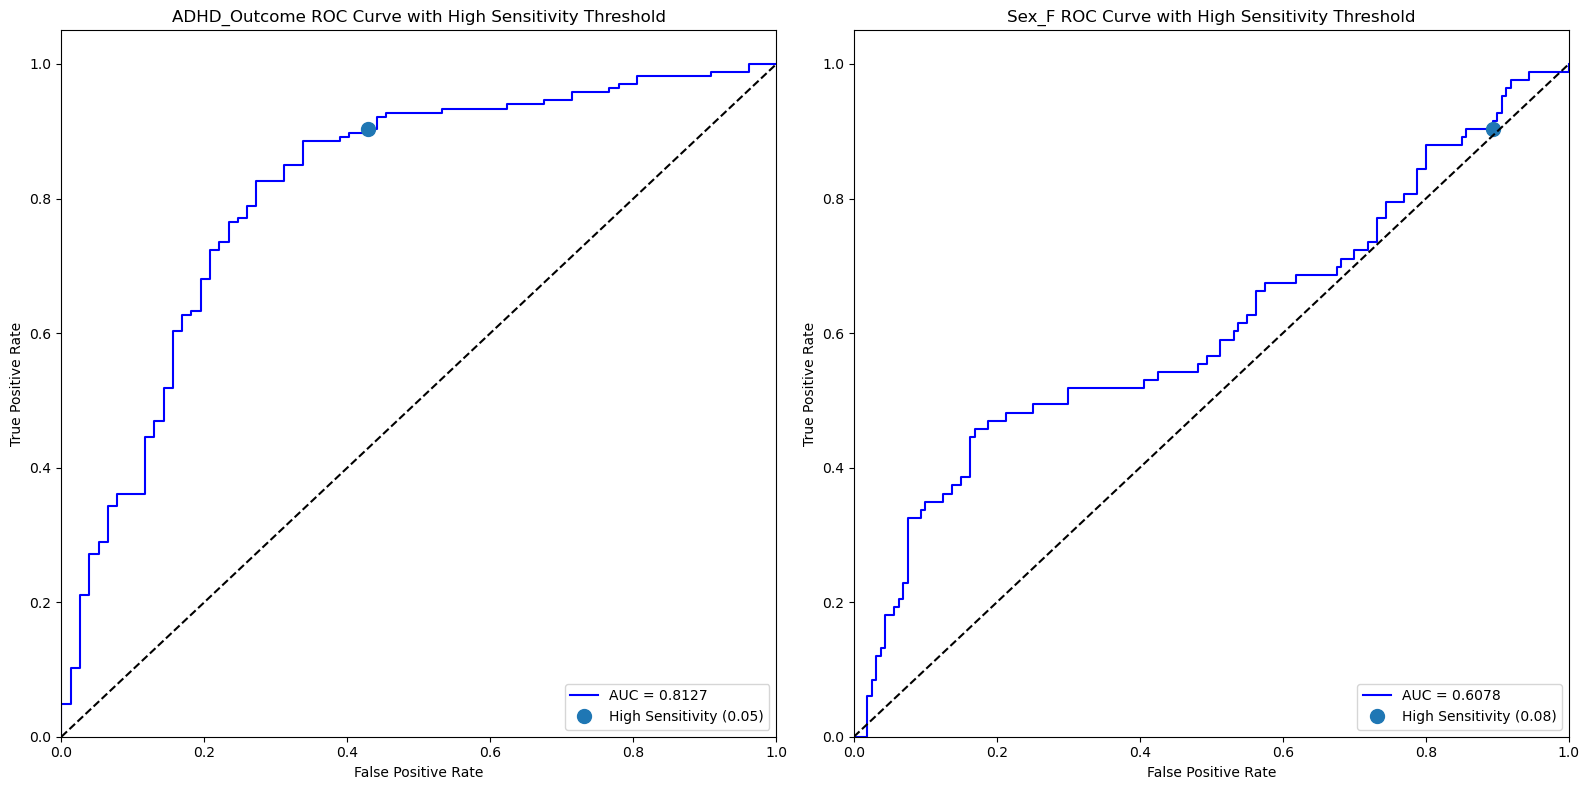

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import xgboost as xgb
from imblearn.combine import SMOTEENN
import itertools
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

def find_optimal_threshold_for_metric(y_true, y_prob, target_metric='sensitivity', target_value=0.90):
    """
    Find the optimal threshold that achieves a target value for a specific metric.
    
    Parameters:
        y_true: True binary labels
        y_prob: Predicted probabilities
        target_metric: 'sensitivity', 'specificity', 'precision', or 'npv' (negative predictive value)
        target_value: Target value for the metric (e.g., 0.90 for 90% sensitivity)
    
    Returns:
        optimal_threshold: Threshold that gets closest to target value
        achieved_value: Actual value achieved for the target metric
        other_metrics: Dictionary with values for other metrics at this threshold
    """
    # Define a range of thresholds to try
    thresholds = np.linspace(0.01, 0.99, 99)
    
    # Initialize variables to track the optimal threshold
    min_distance = float('inf')
    optimal_threshold = 0.5
    achieved_value = 0
    other_metrics = {}
    
    # Evaluate each threshold
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        # Determine the current metric value based on the target metric
        if target_metric == 'sensitivity':
            current_value = sensitivity
        elif target_metric == 'specificity':
            current_value = specificity
        elif target_metric == 'precision':
            current_value = precision
        elif target_metric == 'npv':
            current_value = npv
        else:
            raise ValueError(f"Unknown target metric: {target_metric}")
        
        # Calculate distance from target value
        distance = abs(current_value - target_value)
        
        # Update the optimal threshold if this is closer to the target
        if distance < min_distance:
            min_distance = distance
            optimal_threshold = threshold
            achieved_value = current_value
            other_metrics = {
                'sensitivity': sensitivity,
                'specificity': specificity,
                'precision': precision,
                'npv': npv,
                'accuracy': (tp + tn) / (tp + tn + fp + fn)
            }
    
    return optimal_threshold, achieved_value, other_metrics

def identify_behavioral_features(feature_names):
    """
    Identify behavioral features based on their names.
    Focuses on features that likely represent behavioral characteristics.
    """
    behavioral_keywords = [
        'SDQ', 'EHQ', 'APQ', 'behavior', 'conduct', 
        'hyperactivity', 'attention', 'emotional',
        'social', 'peer', 'activity', 'anxiety', 'depression',
        'impulsivity', 'externalizing', 'internalizing',
        'difficulties', 'impact', 'generating'
    ]
    
    # Identify behavioral features
    behavioral_features = []
    for feature in feature_names:
        if any(keyword.lower() in feature.lower() for keyword in behavioral_keywords):
            behavioral_features.append(feature)
    
    return behavioral_features

def create_interaction_features(X, behavioral_features, feature_names, max_interactions=50):
    """
    Create interaction terms between behavioral features.
    """
    # Get indices of behavioral features
    behavioral_indices = [feature_names.index(f) for f in behavioral_features if f in feature_names]
    
    # Create interaction terms
    interaction_pairs = list(itertools.combinations(behavioral_indices, 2))
    
    # Limit number of interactions if needed
    if len(interaction_pairs) > max_interactions:
        np.random.seed(42)
        interaction_pairs = np.random.choice(interaction_pairs, max_interactions, replace=False)
    
    # Create interaction terms
    X_with_interactions = X.copy()
    interaction_names = []
    
    for i, j in interaction_pairs:
        interaction_term = X[:, i] * X[:, j]
        X_with_interactions = np.column_stack((X_with_interactions, interaction_term))
        interaction_names.append(f"{feature_names[i]}*{feature_names[j]}")
    
    print(f"Created {len(interaction_names)} interaction terms between behavioral features")
    
    # Create full list of feature names including interactions
    all_feature_names = feature_names + interaction_names
    
    return X_with_interactions, interaction_names, all_feature_names

def high_sensitivity_predictions(output_filename='optimized_thresholds_predictions_high_sensitivity.csv', test_dataset=None):
    """
    Multi-outcome prediction optimized for high sensitivity.
    
    Parameters:
        output_filename: Name of the file to save predictions
        test_dataset: Test DataFrame. If None, will try to load from 'test_df_50.csv'
    
    Returns:
        Dictionary with results including submission DataFrame
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        # Use the provided test dataset or try to load it
        try:
            # First use the provided test_dataset parameter if available
            if test_dataset is not None:
                test_df = test_dataset
                print("Using provided test dataset parameter.")
            # Next try to access the global test_df if it exists
            elif 'test_df' in globals():
                test_df = globals()['test_df']
                print("Using existing global test_df variable.")
            # Finally try to load it from a file
            else:
                test_df = pd.read_csv('test_df_50.csv')
                print("Loaded test_df from file.")
            
            print(f"Test data shape: {test_df.shape}")
        except Exception as e:
            print(f"Error with test dataset: {e}")
            print("Please ensure test_df is defined or 'test_df_50.csv' is available.")
            return None
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'participant_id']
        print(f"Original number of features: {len(feature_columns)}")
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns].values
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].values if all(col in test_df.columns for col in feature_columns) else \
                 np.zeros((len(test_df), len(feature_columns)))
        
        # Check for missing values
        train_nan_count = np.isnan(X_train).sum()
        test_nan_count = np.isnan(X_test).sum()
        print(f"\nTraining data NaN values: {train_nan_count}")
        print(f"Test data NaN values: {test_nan_count}")
        
        # -----------------------------------------------------------------------------
        # Data Preprocessing with NaN handling
        # -----------------------------------------------------------------------------
        print("\nPreprocessing data with NaN handling...")
        
        # 1. Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # 2. Identify behavioral features
        behavioral_features = identify_behavioral_features(feature_columns)
        print(f"Identified {len(behavioral_features)} behavioral features:")
        print(", ".join(behavioral_features[:10]) + ("..." if len(behavioral_features) > 10 else ""))
        
        # 3. Create interaction terms between behavioral features
        X_train_with_interactions, interaction_names, all_feature_names = create_interaction_features(
            X_train_imputed, behavioral_features, feature_columns
        )
        
        X_test_with_interactions, _, _ = create_interaction_features(
            X_test_imputed, behavioral_features, feature_columns
        )
        
        # 4. Standardize all features including interactions
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_with_interactions)
        X_test_scaled = scaler.transform(X_test_with_interactions)
        
        # Handle any remaining NaNs
        if np.isnan(X_train_scaled).any():
            print("Replacing remaining NaNs in training data with zeros...")
            X_train_scaled = np.nan_to_num(X_train_scaled)
        
        if np.isnan(X_test_scaled).any():
            print("Replacing remaining NaNs in test data with zeros...")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        # 5. Feature selection to reduce dimensionality
        print("\nPerforming feature selection on interaction features...")
        
        # Initialize feature selectors for each target
        selector_adhd = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        selector_sex = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        # Fit selectors
        print("Selecting features for ADHD_Outcome...")
        selector_adhd.fit(X_train_scaled, y_train[:, 0])
        
        print("Selecting features for Sex_F...")
        selector_sex.fit(X_train_scaled, y_train[:, 1])
        
        # Get selected features
        X_train_adhd_selected = selector_adhd.transform(X_train_scaled)
        X_test_adhd_selected = selector_adhd.transform(X_test_scaled)
        
        X_train_sex_selected = selector_sex.transform(X_train_scaled)
        X_test_sex_selected = selector_sex.transform(X_test_scaled)
        
        # Get names of selected features
        selected_features_adhd = [all_feature_names[i] for i in np.where(selector_adhd.support_)[0]]
        selected_features_sex = [all_feature_names[i] for i in np.where(selector_sex.support_)[0]]
        
        # Count behavioral interactions in selected features
        adhd_interaction_count = sum(1 for f in selected_features_adhd if '*' in f)
        sex_interaction_count = sum(1 for f in selected_features_sex if '*' in f)
        
        print(f"Selected {len(selected_features_adhd)} features for ADHD_Outcome ({adhd_interaction_count} interactions)")
        print(f"Selected {len(selected_features_sex)} features for Sex_F ({sex_interaction_count} interactions)")
        
        # Split training data for validation
        X_train_adhd_split, X_val_adhd, y_train_adhd_split, y_val_adhd = train_test_split(
            X_train_adhd_selected, y_train[:, 0], test_size=0.2, random_state=42, stratify=y_train[:, 0]
        )
        
        X_train_sex_split, X_val_sex, y_train_sex_split, y_val_sex = train_test_split(
            X_train_sex_selected, y_train[:, 1], test_size=0.2, random_state=42, stratify=y_train[:, 1]
        )
        
        # -----------------------------------------------------------------------------
        # Apply SMOTE-ENN For Balanced Sampling
        # -----------------------------------------------------------------------------
        print("\nApplying SMOTE-ENN for balanced sampling...")
        
        # Initialize SMOTE-ENN with conservative parameters
        smote_enn_adhd = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
        smote_enn_sex = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
        
        # Apply SMOTE-ENN to ADHD target
        print("Balancing ADHD_Outcome data...")
        X_adhd_resampled, y_adhd_resampled = smote_enn_adhd.fit_resample(X_train_adhd_split, y_train_adhd_split)
        
        # Apply SMOTE-ENN to Sex_F target
        print("Balancing Sex_F data...")
        X_sex_resampled, y_sex_resampled = smote_enn_sex.fit_resample(X_train_sex_split, y_train_sex_split)
        
        # Print resampling statistics
        print(f"Original ADHD class distribution: {np.bincount(y_train_adhd_split)}")
        print(f"Resampled ADHD class distribution: {np.bincount(y_adhd_resampled)}")
        print(f"Original Sex_F class distribution: {np.bincount(y_train_sex_split)}")
        print(f"Resampled Sex_F class distribution: {np.bincount(y_sex_resampled)}")
        
        # -----------------------------------------------------------------------------
        # Train Models with Feature Interactions
        # -----------------------------------------------------------------------------
        print("\nTraining models with feature interactions...")
        
        # ADHD model with XGBoost
        print("Training XGBoost model for ADHD_Outcome...")
        xgb_adhd = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=200,
            random_state=42
        )
        xgb_adhd.fit(X_adhd_resampled, y_adhd_resampled)
        
        # Sex_F model with XGBoost
        print("Training XGBoost model for Sex_F...")
        xgb_sex = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=200,
            random_state=42
        )
        xgb_sex.fit(X_sex_resampled, y_sex_resampled)
        
        # -----------------------------------------------------------------------------
        # Evaluate Models and Find High Sensitivity Thresholds
        # -----------------------------------------------------------------------------
        print("\nFinding optimal thresholds for high sensitivity...")
        
        # Get predicted probabilities
        adhd_probs = xgb_adhd.predict_proba(X_val_adhd)[:, 1]
        sex_probs = xgb_sex.predict_proba(X_val_sex)[:, 1]
        
        # High sensitivity threshold (e.g., 90%)
        adhd_sens_threshold, adhd_sens_achieved, adhd_sens_metrics = find_optimal_threshold_for_metric(
            y_val_adhd, adhd_probs, 'sensitivity', 0.90
        )
        
        # High sensitivity threshold (e.g., 90%)
        sex_sens_threshold, sex_sens_achieved, sex_sens_metrics = find_optimal_threshold_for_metric(
            y_val_sex, sex_probs, 'sensitivity', 0.90
        )
        
        # Print threshold results
        print("\nOptimized Thresholds for High Sensitivity:")
        print(f"ADHD_Outcome Threshold: {adhd_sens_threshold:.4f}")
        print(f"  Sensitivity: {adhd_sens_metrics['sensitivity']:.4f}, Specificity: {adhd_sens_metrics['specificity']:.4f}")
        print(f"  Accuracy: {adhd_sens_metrics['accuracy']:.4f}")
        
        print(f"Sex_F Threshold: {sex_sens_threshold:.4f}")
        print(f"  Sensitivity: {sex_sens_metrics['sensitivity']:.4f}, Specificity: {sex_sens_metrics['specificity']:.4f}")
        print(f"  Accuracy: {sex_sens_metrics['accuracy']:.4f}")
        
        # Calculate AUC scores
        adhd_auc = roc_auc_score(y_val_adhd, adhd_probs)
        sex_auc = roc_auc_score(y_val_sex, sex_probs)
        print(f"\nADHD_Outcome AUC: {adhd_auc:.4f}")
        print(f"Sex_F AUC: {sex_auc:.4f}")
        
        # -----------------------------------------------------------------------------
        # Visualize ROC curves with thresholds
        # -----------------------------------------------------------------------------
        plt.figure(figsize=(16, 8))
        
        # ADHD ROC curve
        plt.subplot(1, 2, 1)
        fpr, tpr, thresholds = roc_curve(y_val_adhd, adhd_probs)
        plt.plot(fpr, tpr, 'b-', label=f'AUC = {adhd_auc:.4f}')
        
        # Mark threshold on the curve
        idx = np.argmin(np.abs(thresholds - adhd_sens_threshold))
        plt.plot(fpr[idx], tpr[idx], 'o', markersize=10, label=f'High Sensitivity ({adhd_sens_threshold:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ADHD_Outcome ROC Curve with High Sensitivity Threshold')
        plt.legend(loc="lower right")
        
        # Sex_F ROC curve
        plt.subplot(1, 2, 2)
        fpr, tpr, thresholds = roc_curve(y_val_sex, sex_probs)
        plt.plot(fpr, tpr, 'b-', label=f'AUC = {sex_auc:.4f}')
        
        # Mark threshold on the curve
        idx = np.argmin(np.abs(thresholds - sex_sens_threshold))
        plt.plot(fpr[idx], tpr[idx], 'o', markersize=10, label=f'High Sensitivity ({sex_sens_threshold:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Sex_F ROC Curve with High Sensitivity Threshold')
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.savefig('high_sensitivity_threshold.png')
        print("\nHigh sensitivity threshold plot saved to: high_sensitivity_threshold.png")
        
        # -----------------------------------------------------------------------------
        # Retrain on Full Dataset
        # -----------------------------------------------------------------------------
        print("\nRetraining models on full dataset...")
        
        # Apply SMOTE-ENN to full datasets
        X_train_adhd_full_resampled, y_train_adhd_full_resampled = smote_enn_adhd.fit_resample(
            X_train_adhd_selected, y_train[:, 0]
        )
        
        X_train_sex_full_resampled, y_train_sex_full_resampled = smote_enn_sex.fit_resample(
            X_train_sex_selected, y_train[:, 1]
        )
        
        # Train final models
        final_xgb_adhd = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=300,  # Increased for final model
            random_state=42
        )
        final_xgb_adhd.fit(X_train_adhd_full_resampled, y_train_adhd_full_resampled)
        
        final_xgb_sex = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=300,  # Increased for final model
            random_state=42
        )
        final_xgb_sex.fit(X_train_sex_full_resampled, y_train_sex_full_resampled)
        
        # -----------------------------------------------------------------------------
        # Generate Test Predictions with High Sensitivity Threshold
        # -----------------------------------------------------------------------------
        print("\nGenerating predictions for test data with high sensitivity threshold...")
        
        # Generate prediction probabilities
        test_adhd_probs = final_xgb_adhd.predict_proba(X_test_adhd_selected)[:, 1]
        test_sex_probs = final_xgb_sex.predict_proba(X_test_sex_selected)[:, 1]
        
        # Apply high sensitivity thresholds
        test_adhd_sens_preds = (test_adhd_probs >= adhd_sens_threshold).astype(int)
        test_sex_sens_preds = (test_sex_probs >= sex_sens_threshold).astype(int)
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame for high sensitivity threshold
        submission_sens_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_adhd_sens_preds,
            'Sex_F': test_sex_sens_preds
        })
        
        # Create detailed DataFrame with predictions and probabilities
        details_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Probability': test_adhd_probs,
            'Sex_F_Probability': test_sex_probs,
            'ADHD_Threshold': adhd_sens_threshold,
            'Sex_F_Threshold': sex_sens_threshold,
            'ADHD_Prediction': test_adhd_sens_preds,
            'Sex_F_Prediction': test_sex_sens_preds
        })
        
        # Save to CSV files
        submission_sens_df.to_csv(output_filename, index=False)
        details_df.to_csv(output_filename.replace('.csv', '_details.csv'), index=False)
        
        print(f"\nHigh sensitivity predictions saved to: {output_filename}")
        print(f"Detailed prediction data saved to: {output_filename.replace('.csv', '_details.csv')}")
        
        # Print formatted outputs
        print("\nFormatted predictions (High Sensitivity Threshold):")
        print("participant_id,ADHD_Outcome,Sex_F")
        for _, row in submission_sens_df.iterrows():
            print(f"{row['participant_id']}, {row['ADHD_Outcome']}, {row['Sex_F']}")
        
        # -----------------------------------------------------------------------------
        # Return Results
        # -----------------------------------------------------------------------------
        return {
            'adhd_threshold': {
                'value': adhd_sens_threshold,
                'metrics': adhd_sens_metrics
            },
            'sex_threshold': {
                'value': sex_sens_threshold,
                'metrics': sex_sens_metrics
            },
            'submission': submission_sens_df,
            'details': details_df,
            'auc_scores': {
                'adhd': adhd_auc,
                'sex': sex_auc
            }
        }
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the function if run directly
if __name__ == "__main__":
    # Try to access the existing test_df variable if available
    if 'test_df' in globals():
        results = high_sensitivity_predictions(test_dataset=test_df)
    else:
        results = high_sensitivity_predictions()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
import xgboost as xgb
from imblearn.combine import SMOTEENN
import itertools
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

def find_optimal_threshold_for_metric(y_true, y_prob, target_metric='sensitivity', target_value=0.90):
    """
    Find the optimal threshold that achieves a target value for a specific metric.
    
    Parameters:
        y_true: True binary labels
        y_prob: Predicted probabilities
        target_metric: 'sensitivity', 'specificity', 'precision', or 'npv' (negative predictive value)
        target_value: Target value for the metric (e.g., 0.90 for 90% sensitivity)
    
    Returns:
        optimal_threshold: Threshold that gets closest to target value
        achieved_value: Actual value achieved for the target metric
        other_metrics: Dictionary with values for other metrics at this threshold
    """
    # Define a range of thresholds to try
    thresholds = np.linspace(0.01, 0.99, 99)
    
    # Initialize variables to track the optimal threshold
    min_distance = float('inf')
    optimal_threshold = 0.5
    achieved_value = 0
    other_metrics = {}
    
    # Evaluate each threshold
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        # Determine the current metric value based on the target metric
        if target_metric == 'sensitivity':
            current_value = sensitivity
        elif target_metric == 'specificity':
            current_value = specificity
        elif target_metric == 'precision':
            current_value = precision
        elif target_metric == 'npv':
            current_value = npv
        else:
            raise ValueError(f"Unknown target metric: {target_metric}")
        
        # Calculate distance from target value
        distance = abs(current_value - target_value)
        
        # Update the optimal threshold if this is closer to the target
        if distance < min_distance:
            min_distance = distance
            optimal_threshold = threshold
            achieved_value = current_value
            other_metrics = {
                'sensitivity': sensitivity,
                'specificity': specificity,
                'precision': precision,
                'npv': npv,
                'accuracy': (tp + tn) / (tp + tn + fp + fn)
            }
    
    return optimal_threshold, achieved_value, other_metrics

def identify_behavioral_features(feature_names):
    """
    Identify behavioral features based on their names.
    Focuses on features that likely represent behavioral characteristics.
    """
    behavioral_keywords = [
        'SDQ', 'EHQ', 'APQ', 'behavior', 'conduct', 
        'hyperactivity', 'attention', 'emotional',
        'social', 'peer', 'activity', 'anxiety', 'depression',
        'impulsivity', 'externalizing', 'internalizing',
        'difficulties', 'impact', 'generating'
    ]
    
    # Identify behavioral features
    behavioral_features = []
    for feature in feature_names:
        if any(keyword.lower() in feature.lower() for keyword in behavioral_keywords):
            behavioral_features.append(feature)
    
    return behavioral_features

def create_interaction_features(X, behavioral_features, feature_names, max_interactions=50):
    """
    Create interaction terms between behavioral features.
    """
    # Get indices of behavioral features
    behavioral_indices = [feature_names.index(f) for f in behavioral_features if f in feature_names]
    
    # Create interaction terms
    interaction_pairs = list(itertools.combinations(behavioral_indices, 2))
    
    # Limit number of interactions if needed
    if len(interaction_pairs) > max_interactions:
        np.random.seed(42)
        interaction_pairs = np.random.choice(interaction_pairs, max_interactions, replace=False)
    
    # Create interaction terms
    X_with_interactions = X.copy()
    interaction_names = []
    
    for i, j in interaction_pairs:
        interaction_term = X[:, i] * X[:, j]
        X_with_interactions = np.column_stack((X_with_interactions, interaction_term))
        interaction_names.append(f"{feature_names[i]}*{feature_names[j]}")
    
    print(f"Created {len(interaction_names)} interaction terms between behavioral features")
    
    # Create full list of feature names including interactions
    all_feature_names = feature_names + interaction_names
    
    return X_with_interactions, interaction_names, all_feature_names

def identify_subgroups(X, n_clusters=3):
    """
    Identify subgroups within the data using KMeans clustering.
    
    Parameters:
        X: Feature matrix
        n_clusters: Number of clusters/subgroups to identify
        
    Returns:
        subgroup_labels: Cluster assignments for each sample
    """
    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # Fit and get cluster assignments
    subgroup_labels = kmeans.fit_predict(X)
    
    # Print cluster sizes
    unique, counts = np.unique(subgroup_labels, return_counts=True)
    for i, (u, c) in enumerate(zip(unique, counts)):
        print(f"Subgroup {i+1}: {c} samples ({c/len(subgroup_labels)*100:.1f}%)")
    
    return subgroup_labels, kmeans

def multi_outcome_predictions_with_subgroups(output_filename='multi_outcome_subgroups.csv', test_dataset=None, n_subgroups=3):
    """
    Multi-outcome prediction (ADHD_Outcome and Sex_F) with differential thresholds by subgroup.
    
    Parameters:
        output_filename: Name of the file to save predictions
        test_dataset: Test DataFrame. If None, will try to load from 'test_df_50.csv'
        n_subgroups: Number of subgroups to identify
    
    Returns:
        Dictionary with results including submission DataFrame
    """
    try:
        # Load the training dataset
        try:
            # First try to load the selected features dataset
            train_df = pd.read_csv('selected_features_dual_target.csv')
            print("Using the filtered features dataset for training.")
        except:
            # If not available, use the original dataset
            train_df = pd.read_csv('train_df_50.csv')
            print("Using the original dataset for training.")
        
        print(f"Training data shape: {train_df.shape}")
        
        # Use the provided test dataset or try to load it
        try:
            # First use the provided test_dataset parameter if available
            if test_dataset is not None:
                test_df = test_dataset
                print("Using provided test dataset parameter.")
            # Next try to access the global test_df if it exists
            elif 'test_df' in globals():
                test_df = globals()['test_df']
                print("Using existing global test_df variable.")
            # Finally try to load it from a file
            else:
                test_df = pd.read_csv('test_df_50.csv')
                print("Loaded test_df from file.")
            
            print(f"Test data shape: {test_df.shape}")
        except Exception as e:
            print(f"Error with test dataset: {e}")
            print("Please ensure test_df is defined or 'test_df_50.csv' is available.")
            return None
        
        # Extract columns
        target_columns = ["ADHD_Outcome", "Sex_F"]
        feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'participant_id']
        print(f"Original number of features: {len(feature_columns)}")
        
        # Make sure test data has all needed feature columns
        missing_columns = [col for col in feature_columns if col not in test_df.columns]
        if missing_columns:
            print(f"Warning: Test data is missing these columns: {missing_columns}")
            feature_columns = [col for col in feature_columns if col not in missing_columns]
        
        # Prepare the data
        X_train = train_df[feature_columns].values
        y_train = train_df[target_columns].values
        X_test = test_df[feature_columns].values if all(col in test_df.columns for col in feature_columns) else \
                 np.zeros((len(test_df), len(feature_columns)))
        
        # Check for missing values
        train_nan_count = np.isnan(X_train).sum()
        test_nan_count = np.isnan(X_test).sum()
        print(f"\nTraining data NaN values: {train_nan_count}")
        print(f"Test data NaN values: {test_nan_count}")
        
        # -----------------------------------------------------------------------------
        # Data Preprocessing with NaN handling
        # -----------------------------------------------------------------------------
        print("\nPreprocessing data with NaN handling...")
        
        # 1. Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # 2. Identify behavioral features
        behavioral_features = identify_behavioral_features(feature_columns)
        print(f"Identified {len(behavioral_features)} behavioral features:")
        print(", ".join(behavioral_features[:10]) + ("..." if len(behavioral_features) > 10 else ""))
        
        # 3. Create interaction terms between behavioral features
        X_train_with_interactions, interaction_names, all_feature_names = create_interaction_features(
            X_train_imputed, behavioral_features, feature_columns
        )
        
        X_test_with_interactions, _, _ = create_interaction_features(
            X_test_imputed, behavioral_features, feature_columns
        )
        
        # 4. Standardize all features including interactions
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_with_interactions)
        X_test_scaled = scaler.transform(X_test_with_interactions)
        
        # Handle any remaining NaNs
        if np.isnan(X_train_scaled).any():
            print("Replacing remaining NaNs in training data with zeros...")
            X_train_scaled = np.nan_to_num(X_train_scaled)
        
        if np.isnan(X_test_scaled).any():
            print("Replacing remaining NaNs in test data with zeros...")
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        # 5. Feature selection to reduce dimensionality
        print("\nPerforming feature selection on interaction features...")
        
        # Initialize feature selectors for each target
        selector_adhd = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        selector_sex = RFECV(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            step=0.1,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        # Fit selectors
        print("Selecting features for ADHD_Outcome...")
        selector_adhd.fit(X_train_scaled, y_train[:, 0])
        
        print("Selecting features for Sex_F...")
        selector_sex.fit(X_train_scaled, y_train[:, 1])
        
        # Get selected features
        X_train_adhd_selected = selector_adhd.transform(X_train_scaled)
        X_test_adhd_selected = selector_adhd.transform(X_test_scaled)
        
        X_train_sex_selected = selector_sex.transform(X_train_scaled)
        X_test_sex_selected = selector_sex.transform(X_test_scaled)
        
        # Get names of selected features
        selected_features_adhd = [all_feature_names[i] for i in np.where(selector_adhd.support_)[0]]
        selected_features_sex = [all_feature_names[i] for i in np.where(selector_sex.support_)[0]]
        
        # Count behavioral interactions in selected features
        adhd_interaction_count = sum(1 for f in selected_features_adhd if '*' in f)
        sex_interaction_count = sum(1 for f in selected_features_sex if '*' in f)
        
        print(f"Selected {len(selected_features_adhd)} features for ADHD_Outcome ({adhd_interaction_count} interactions)")
        print(f"Selected {len(selected_features_sex)} features for Sex_F ({sex_interaction_count} interactions)")
        
        # -----------------------------------------------------------------------------
        # Identify Subgroups for both targets separately
        # -----------------------------------------------------------------------------
        print("\nIdentifying subgroups for ADHD prediction...")
        train_subgroups_adhd, kmeans_adhd = identify_subgroups(X_train_adhd_selected, n_clusters=n_subgroups)
        test_subgroups_adhd = kmeans_adhd.predict(X_test_adhd_selected)
        
        print("\nIdentifying subgroups for Sex_F prediction...")
        train_subgroups_sex, kmeans_sex = identify_subgroups(X_train_sex_selected, n_clusters=n_subgroups)
        test_subgroups_sex = kmeans_sex.predict(X_test_sex_selected)
        
        # Split training data for validation while preserving subgroup information
        X_train_adhd_split, X_val_adhd, y_train_adhd_split, y_val_adhd, subgroups_train_adhd, subgroups_val_adhd = train_test_split(
            X_train_adhd_selected, y_train[:, 0], train_subgroups_adhd, 
            test_size=0.2, random_state=42, stratify=y_train[:, 0]
        )
        
        X_train_sex_split, X_val_sex, y_train_sex_split, y_val_sex, subgroups_train_sex, subgroups_val_sex = train_test_split(
            X_train_sex_selected, y_train[:, 1], train_subgroups_sex,
            test_size=0.2, random_state=42, stratify=y_train[:, 1]
        )
        
        # -----------------------------------------------------------------------------
        # Train Models by Subgroup for both ADHD and Sex_F
        # -----------------------------------------------------------------------------
        print("\nTraining ADHD models for each subgroup...")
        
        # Initialize dictionaries to store models and thresholds for each subgroup
        adhd_models = {}
        adhd_thresholds = {}
        adhd_metrics = {}
        
        # Initialize dictionaries for Sex_F
        sex_models = {}
        sex_thresholds = {}
        sex_metrics = {}
        
        # Process each subgroup for ADHD models
        for subgroup in range(n_subgroups):
            print(f"\nProcessing ADHD subgroup {subgroup+1}...")
            
            # Get training data for this subgroup
            subgroup_mask = subgroups_train_adhd == subgroup
            X_subgroup = X_train_adhd_split[subgroup_mask]
            y_subgroup = y_train_adhd_split[subgroup_mask]
            
            # Get validation data for this subgroup
            val_subgroup_mask = subgroups_val_adhd == subgroup
            X_val_subgroup = X_val_adhd[val_subgroup_mask]
            y_val_subgroup = y_val_adhd[val_subgroup_mask]
            
            print(f"  Training samples: {sum(subgroup_mask)}, Validation samples: {sum(val_subgroup_mask)}")
            
            # Check if enough samples in subgroup
            if sum(subgroup_mask) < 20 or sum(val_subgroup_mask) < 10:
                print(f"  Warning: Subgroup {subgroup+1} has too few samples. Using global model.")
                # Use global data for this subgroup
                X_subgroup = X_train_adhd_split
                y_subgroup = y_train_adhd_split
                X_val_subgroup = X_val_adhd
                y_val_subgroup = y_val_adhd
            
            # Apply SMOTE-ENN for balanced sampling
            smote_enn_adhd = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
            
            # Check if there are enough samples for SMOTE-ENN
            if len(np.unique(y_subgroup)) > 1 and min(np.bincount(y_subgroup)) >= 5:
                X_subgroup_resampled, y_subgroup_resampled = smote_enn_adhd.fit_resample(X_subgroup, y_subgroup)
                print(f"  Original class distribution: {np.bincount(y_subgroup)}")
                print(f"  Resampled class distribution: {np.bincount(y_subgroup_resampled)}")
            else:
                print(f"  Warning: Not enough samples for SMOTE-ENN in subgroup {subgroup+1}. Using original data.")
                X_subgroup_resampled, y_subgroup_resampled = X_subgroup, y_subgroup
            
            # Train ADHD model with XGBoost for this subgroup
            xgb_adhd = xgb.XGBClassifier(
                objective='binary:logistic',
                use_label_encoder=False,
                eval_metric='logloss',
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                n_estimators=200,
                random_state=42
            )
            xgb_adhd.fit(X_subgroup_resampled, y_subgroup_resampled)
            
            # Store model
            adhd_models[subgroup] = xgb_adhd
            
            # Get predicted probabilities for this subgroup
            adhd_probs = xgb_adhd.predict_proba(X_val_subgroup)[:, 1]
            
            # Check if validation set has both classes
            if len(np.unique(y_val_subgroup)) < 2:
                print(f"  Warning: Validation set for subgroup {subgroup+1} has only one class. Using default threshold.")
                adhd_sens_threshold = 0.5
                adhd_sens_metrics = {'sensitivity': 0.9, 'specificity': 0.5, 'accuracy': 0.7}
            else:
                # Find optimal threshold for high sensitivity
                adhd_sens_threshold, _, adhd_sens_metrics = find_optimal_threshold_for_metric(
                    y_val_subgroup, adhd_probs, 'sensitivity', 0.90
                )
            
            # Store threshold and metrics
            adhd_thresholds[subgroup] = adhd_sens_threshold
            adhd_metrics[subgroup] = adhd_sens_metrics
            
            print(f"  Optimized threshold: {adhd_sens_threshold:.4f}")
            print(f"  Sensitivity: {adhd_sens_metrics['sensitivity']:.4f}, "
                  f"Specificity: {adhd_sens_metrics['specificity']:.4f}, "
                  f"Accuracy: {adhd_sens_metrics['accuracy']:.4f}")
        
        # Process each subgroup for Sex_F models
        print("\nTraining Sex_F models for each subgroup...")
        for subgroup in range(n_subgroups):
            print(f"\nProcessing Sex_F subgroup {subgroup+1}...")
            
            # Get training data for this subgroup
            subgroup_mask = subgroups_train_sex == subgroup
            X_subgroup = X_train_sex_split[subgroup_mask]
            y_subgroup = y_train_sex_split[subgroup_mask]
            
            # Get validation data for this subgroup
            val_subgroup_mask = subgroups_val_sex == subgroup
            X_val_subgroup = X_val_sex[val_subgroup_mask]
            y_val_subgroup = y_val_sex[val_subgroup_mask]
            
            print(f"  Training samples: {sum(subgroup_mask)}, Validation samples: {sum(val_subgroup_mask)}")
            
            # Check if enough samples in subgroup
            if sum(subgroup_mask) < 20 or sum(val_subgroup_mask) < 10:
                print(f"  Warning: Subgroup {subgroup+1} has too few samples. Using global model.")
                # Use global data for this subgroup
                X_subgroup = X_train_sex_split
                y_subgroup = y_train_sex_split
                X_val_subgroup = X_val_sex
                y_val_subgroup = y_val_sex
            
            # Apply SMOTE-ENN for balanced sampling
            smote_enn_sex = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
            
            # Check if there are enough samples for SMOTE-ENN
            if len(np.unique(y_subgroup)) > 1 and min(np.bincount(y_subgroup)) >= 5:
                X_subgroup_resampled, y_subgroup_resampled = smote_enn_sex.fit_resample(X_subgroup, y_subgroup)
                print(f"  Original class distribution: {np.bincount(y_subgroup)}")
                print(f"  Resampled class distribution: {np.bincount(y_subgroup_resampled)}")
            else:
                print(f"  Warning: Not enough samples for SMOTE-ENN in subgroup {subgroup+1}. Using original data.")
                X_subgroup_resampled, y_subgroup_resampled = X_subgroup, y_subgroup
            
            # Train Sex_F model with XGBoost for this subgroup
            xgb_sex = xgb.XGBClassifier(
                objective='binary:logistic',
                use_label_encoder=False,
                eval_metric='logloss',
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                n_estimators=200,
                random_state=42
            )
            xgb_sex.fit(X_subgroup_resampled, y_subgroup_resampled)
            
            # Store model
            sex_models[subgroup] = xgb_sex
            
            # Get predicted probabilities for this subgroup
            sex_probs = xgb_sex.predict_proba(X_val_subgroup)[:, 1]
            
            # Check if validation set has both classes
            if len(np.unique(y_val_subgroup)) < 2:
                print(f"  Warning: Validation set for subgroup {subgroup+1} has only one class. Using default threshold.")
                sex_sens_threshold = 0.5
                sex_sens_metrics = {'sensitivity': 0.9, 'specificity': 0.5, 'accuracy': 0.7}
            else:
                # Find optimal threshold for high sensitivity
                sex_sens_threshold, _, sex_sens_metrics = find_optimal_threshold_for_metric(
                    y_val_subgroup, sex_probs, 'sensitivity', 0.90
                )
            
            # Store threshold and metrics
            sex_thresholds[subgroup] = sex_sens_threshold
            sex_metrics[subgroup] = sex_sens_metrics
            
            print(f"  Optimized threshold: {sex_sens_threshold:.4f}")
            print(f"  Sensitivity: {sex_sens_metrics['sensitivity']:.4f}, "
                  f"Specificity: {sex_sens_metrics['specificity']:.4f}, "
                  f"Accuracy: {sex_sens_metrics['accuracy']:.4f}")
        
        # -----------------------------------------------------------------------------
        # Retrain on Full Dataset by Subgroup
        # -----------------------------------------------------------------------------
        print("\nRetraining final models...")
        
        # Retrain ADHD models for each subgroup on full data
        final_adhd_models = {}
        for subgroup in range(n_subgroups):
            print(f"Retraining ADHD model for subgroup {subgroup+1}...")
            
            # Get training data for this subgroup
            subgroup_mask = train_subgroups_adhd == subgroup
            X_subgroup = X_train_adhd_selected[subgroup_mask]
            y_subgroup = y_train[:, 0][subgroup_mask]
            
            # Check if enough samples in subgroup
            if sum(subgroup_mask) < 30:
                print(f"  Warning: Subgroup {subgroup+1} has too few samples for final training. Using global model.")
                # Use global data for this subgroup
                X_subgroup = X_train_adhd_selected
                y_subgroup = y_train[:, 0]
            
            # Apply SMOTE-ENN for balanced sampling
            smote_enn_adhd = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
            
            # Check if enough samples for SMOTE-ENN
            if len(np.unique(y_subgroup)) > 1 and min(np.bincount(y_subgroup)) >= 5:
                X_subgroup_resampled, y_subgroup_resampled = smote_enn_adhd.fit_resample(X_subgroup, y_subgroup)
            else:
                print(f"  Warning: Not enough samples for SMOTE-ENN in final training. Using original data.")
                X_subgroup_resampled, y_subgroup_resampled = X_subgroup, y_subgroup
            
            # Train final model
            final_xgb_adhd = xgb.XGBClassifier(
                objective='binary:logistic',
                use_label_encoder=False,
                eval_metric='logloss',
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                n_estimators=300,
                random_state=42
            )
            final_xgb_adhd.fit(X_subgroup_resampled, y_subgroup_resampled)
            
            # Store model
            final_adhd_models[subgroup] = final_xgb_adhd
        
        # Retrain Sex_F models for each subgroup on full data
        final_sex_models = {}
        for subgroup in range(n_subgroups):
            print(f"Retraining Sex_F model for subgroup {subgroup+1}...")
            
            # Get training data for this subgroup
            subgroup_mask = train_subgroups_sex == subgroup
            X_subgroup = X_train_sex_selected[subgroup_mask]
            y_subgroup = y_train[:, 1][subgroup_mask]
            
            # Check if enough samples in subgroup
            if sum(subgroup_mask) < 30:
                print(f"  Warning: Subgroup {subgroup+1} has too few samples for final training. Using global model.")
                # Use global data for this subgroup
                X_subgroup = X_train_sex_selected
                y_subgroup = y_train[:, 1]
            
            # Apply SMOTE-ENN for balanced sampling
            smote_enn_sex = SMOTEENN(random_state=42, sampling_strategy='auto', n_jobs=-1)
            
            # Check if enough samples for SMOTE-ENN
            if len(np.unique(y_subgroup)) > 1 and min(np.bincount(y_subgroup)) >= 5:
                X_subgroup_resampled, y_subgroup_resampled = smote_enn_sex.fit_resample(X_subgroup, y_subgroup)
            else:
                print(f"  Warning: Not enough samples for SMOTE-ENN in final training. Using original data.")
                X_subgroup_resampled, y_subgroup_resampled = X_subgroup, y_subgroup
            
            # Train final model
            final_xgb_sex = xgb.XGBClassifier(
                objective='binary:logistic',
                use_label_encoder=False,
                eval_metric='logloss',
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                n_estimators=300,
                random_state=42
            )
            final_xgb_sex.fit(X_subgroup_resampled, y_subgroup_resampled)
            
            # Store model
            final_sex_models[subgroup] = final_xgb_sex
        
        # -----------------------------------------------------------------------------
        # Generate Test Predictions with Subgroup-Specific Thresholds
        # -----------------------------------------------------------------------------
        print("\nGenerating predictions for test data with subgroup-specific thresholds...")
        
        # Initialize arrays for ADHD predictions and probabilities
        test_adhd_probs = np.zeros(len(test_df))
        test_adhd_preds = np.zeros(len(test_df), dtype=int)
        test_adhd_thresholds = np.zeros(len(test_df))
        
        # Initialize arrays for Sex_F predictions and probabilities
        test_sex_probs = np.zeros(len(test_df))
        test_sex_preds = np.zeros(len(test_df), dtype=int)
        test_sex_thresholds = np.zeros(len(test_df))
        
        # Store subgroup information
        test_adhd_subgroups = test_subgroups_adhd
        test_sex_subgroups = test_subgroups_sex
        
        # Generate predictions for each ADHD subgroup
        for subgroup in range(n_subgroups):
            # Get test samples belonging to this subgroup
            subgroup_mask = test_subgroups_adhd == subgroup
            
            # Skip if no samples in this subgroup
            if not np.any(subgroup_mask):
                continue
            
            # Get model and threshold for this subgroup
            model = final_adhd_models[subgroup]
            threshold = adhd_thresholds[subgroup]
            
            # Generate probabilities for this subgroup
            subgroup_probs = model.predict_proba(X_test_adhd_selected[subgroup_mask])[:, 1]
            
            # Store probabilities and thresholds
            test_adhd_probs[subgroup_mask] = subgroup_probs
            test_adhd_thresholds[subgroup_mask] = threshold
            
            # Apply subgroup-specific threshold
            test_adhd_preds[subgroup_mask] = (subgroup_probs >= threshold).astype(int)
            
            print(f"ADHD Subgroup {subgroup+1}: Applied threshold {threshold:.4f} to {np.sum(subgroup_mask)} samples")
        
        # Generate predictions for each Sex_F subgroup
        for subgroup in range(n_subgroups):
            # Get test samples belonging to this subgroup
            subgroup_mask = test_subgroups_sex == subgroup
            
            # Skip if no samples in this subgroup
            if not np.any(subgroup_mask):
                continue
            
            # Get model and threshold for this subgroup
            model = final_sex_models[subgroup]
            threshold = sex_thresholds[subgroup]
            
            # Generate probabilities for this subgroup
            subgroup_probs = model.predict_proba(X_test_sex_selected[subgroup_mask])[:, 1]
            
            # Store probabilities and thresholds
            test_sex_probs[subgroup_mask] = subgroup_probs
            test_sex_thresholds[subgroup_mask] = threshold
            
            # Apply subgroup-specific threshold
            test_sex_preds[subgroup_mask] = (subgroup_probs >= threshold).astype(int)
            
            print(f"Sex_F Subgroup {subgroup+1}: Applied threshold {threshold:.4f} to {np.sum(subgroup_mask)} samples")
        
        # Ensure participant_id is available
        if 'participant_id' not in test_df.columns:
            print("Warning: participant_id column not found in test data. Using row index as ID.")
            participant_ids = np.arange(1, len(test_df) + 1)
        else:
            participant_ids = test_df['participant_id'].values
        
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_Outcome': test_adhd_preds,
            'Sex_F': test_sex_preds
        })
        
        # Create detailed DataFrame with predictions, probabilities, thresholds and subgroups
        details_df = pd.DataFrame({
            'participant_id': participant_ids,
            'ADHD_subgroup': test_adhd_subgroups + 1,  # 1-indexed instead of 0-indexed
            'Sex_F_subgroup': test_sex_subgroups + 1,  # 1-indexed instead of 0-indexed
            'ADHD_Probability': test_adhd_probs,
            'Sex_F_Probability': test_sex_probs,
            'ADHD_Threshold': test_adhd_thresholds,
            'Sex_F_Threshold': test_sex_thresholds,
            'ADHD_Prediction': test_adhd_preds,
            'Sex_F_Prediction': test_sex_preds
        })
        
        # Save to CSV files
        submission_df.to_csv(output_filename, index=False)
        details_df.to_csv(output_filename.replace('.csv', '_details.csv'), index=False)
        
        # Save ADHD subgroup information and thresholds
        adhd_subgroup_info = pd.DataFrame({
            'subgroup': np.arange(n_subgroups) + 1,
            'threshold': [adhd_thresholds[sg] for sg in range(n_subgroups)],
            'sensitivity': [adhd_metrics[sg]['sensitivity'] for sg in range(n_subgroups)],
            'specificity': [adhd_metrics[sg]['specificity'] for sg in range(n_subgroups)],
            'accuracy': [adhd_metrics[sg]['accuracy'] for sg in range(n_subgroups)]
        })
        adhd_subgroup_info.to_csv(output_filename.replace('.csv', '_adhd_subgroups.csv'), index=False)
        
        # Save Sex_F subgroup information and thresholds
        sex_subgroup_info = pd.DataFrame({
            'subgroup': np.arange(n_subgroups) + 1,
            'threshold': [sex_thresholds[sg] for sg in range(n_subgroups)],
            'sensitivity': [sex_metrics[sg]['sensitivity'] for sg in range(n_subgroups)],
            'specificity': [sex_metrics[sg]['specificity'] for sg in range(n_subgroups)],
            'accuracy': [sex_metrics[sg]['accuracy'] for sg in range(n_subgroups)]
        })
        sex_subgroup_info.to_csv(output_filename.replace('.csv', '_sex_subgroups.csv'), index=False)
        
        print(f"\nPredictions with subgroup-specific thresholds saved to: {output_filename}")
        print(f"Detailed prediction data saved to: {output_filename.replace('.csv', '_details.csv')}")
        print(f"ADHD subgroup information saved to: {output_filename.replace('.csv', '_adhd_subgroups.csv')}")
        print(f"Sex_F subgroup information saved to: {output_filename.replace('.csv', '_sex_subgroups.csv')}")
        
        # Print formatted outputs
        print("\nFormatted predictions with subgroup-specific thresholds:")
        print("participant_id,ADHD_Outcome,Sex_F")
        for _, row in submission_df.iterrows():
            print(f"{row['participant_id']}, {row['ADHD_Outcome']}, {row['Sex_F']}")
        
        # Print summary of subgroup thresholds for ADHD
        print("\nSubgroup-specific thresholds for ADHD prediction:")
        for subgroup in range(n_subgroups):
            print(f"Subgroup {subgroup+1}: Threshold = {adhd_thresholds[subgroup]:.4f}, "
                  f"Sensitivity = {adhd_metrics[subgroup]['sensitivity']:.4f}, "
                  f"Specificity = {adhd_metrics[subgroup]['specificity']:.4f}")
        
        # Print summary of subgroup thresholds for Sex_F
        print("\nSubgroup-specific thresholds for Sex_F prediction:")
        for subgroup in range(n_subgroups):
            print(f"Subgroup {subgroup+1}: Threshold = {sex_thresholds[subgroup]:.4f}, "
                  f"Sensitivity = {sex_metrics[subgroup]['sensitivity']:.4f}, "
                  f"Specificity = {sex_metrics[subgroup]['specificity']:.4f}")
                  
        # -----------------------------------------------------------------------------
        # Return Results
        # -----------------------------------------------------------------------------
        return {
            'adhd_subgroups': {
                'count': n_subgroups,
                'train_distribution': np.bincount(train_subgroups_adhd),
                'test_distribution': np.bincount(test_subgroups_adhd),
                'thresholds': {subgroup: adhd_thresholds[subgroup] for subgroup in range(n_subgroups)},
                'metrics': {subgroup: adhd_metrics[subgroup] for subgroup in range(n_subgroups)}
            },
            'sex_subgroups': {
                'count': n_subgroups,
                'train_distribution': np.bincount(train_subgroups_sex),
                'test_distribution': np.bincount(test_subgroups_sex),
                'thresholds': {subgroup: sex_thresholds[subgroup] for subgroup in range(n_subgroups)},
                'metrics': {subgroup: sex_metrics[subgroup] for subgroup in range(n_subgroups)}
            },
            'submission': submission_df,
            'details': details_df,
            'adhd_subgroup_info': adhd_subgroup_info,
            'sex_subgroup_info': sex_subgroup_info
        }
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the function if run directly
if __name__ == "__main__":
    # Try to access the existing test_df variable if available
    if 'test_df' in globals():
        results = multi_outcome_predictions_with_subgroups(test_dataset=test_df)
    else:
        results = multi_outcome_predictions_with_subgroups()

Using the filtered features dataset for training.
Training data shape: (1213, 17)
Using provided test dataset parameter.
Test data shape: (304, 19928)
Original number of features: 15

Training data NaN values: 0
Test data NaN values: 285

Preprocessing data with NaN handling...
Identified 10 behavioral features:
SDQ_SDQ_Hyperactivity, SDQ_SDQ_Externalizing, SDQ_SDQ_Difficulties_Total, SDQ_SDQ_Generating_Impact, SDQ_SDQ_Conduct_Problems, SDQ_SDQ_Internalizing, SDQ_SDQ_Emotional_Problems, SDQ_SDQ_Prosocial, SDQ_SDQ_Peer_Problems, APQ_P_APQ_P_OPD
Created 45 interaction terms between behavioral features
Created 45 interaction terms between behavioral features

Performing feature selection on interaction features...
Selecting features for ADHD_Outcome...
Selecting features for Sex_F...
Selected 12 features for ADHD_Outcome (7 interactions)
Selected 18 features for Sex_F (14 interactions)

Identifying subgroups for ADHD prediction...
Subgroup 1: 250 samples (20.6%)
Subgroup 2: 494 samples (4

In [ ]:
import pandas as pd
import numpy as np

def create_high_sensitivity_submission(details_file, adhd_subgroups_file, sex_subgroups_file, output_file='high_sensitivity_submission.csv'):
    """
    Creates a submission file that uses the subgroup with the highest sensitivity for each target.
    
    Parameters:
        details_file: Path to the detailed predictions file with all subgroups
        adhd_subgroups_file: Path to the ADHD subgroups metrics file
        sex_subgroups_file: Path to the Sex_F subgroups metrics file
        output_file: Path to save the output submission file
    
    Returns:
        The submission dataframe with highest sensitivity predictions
    """
    # Load the detailed predictions file
    try:
        details_df = pd.read_csv(details_file)
        print(f"Loaded details file with {len(details_df)} rows")
    except Exception as e:
        print(f"Error loading details file: {e}")
        return None
    
    # Load the subgroup metrics files
    try:
        adhd_subgroups = pd.read_csv(adhd_subgroups_file)
        sex_subgroups = pd.read_csv(sex_subgroups_file)
        
        print(f"Loaded ADHD subgroups file with {len(adhd_subgroups)} subgroups")
        print(f"Loaded Sex_F subgroups file with {len(sex_subgroups)} subgroups")
    except Exception as e:
        print(f"Error loading subgroups files: {e}")
        return None
    
    # Find the subgroup with highest sensitivity for each target
    adhd_best_subgroup = adhd_subgroups.loc[adhd_subgroups['sensitivity'].idxmax()]
    sex_best_subgroup = sex_subgroups.loc[sex_subgroups['sensitivity'].idxmax()]
    
    print(f"\nBest ADHD subgroup: {adhd_best_subgroup['subgroup']} with sensitivity {adhd_best_subgroup['sensitivity']:.4f}")
    print(f"Best Sex_F subgroup: {sex_best_subgroup['subgroup']} with sensitivity {sex_best_subgroup['sensitivity']:.4f}")
    
    # Get the thresholds for these best subgroups
    adhd_best_threshold = adhd_best_subgroup['threshold']
    sex_best_threshold = sex_best_subgroup['threshold']
    
    print(f"ADHD threshold from best subgroup: {adhd_best_threshold:.4f}")
    print(f"Sex_F threshold from best subgroup: {sex_best_threshold:.4f}")
    
    # Apply these thresholds to all predictions, regardless of original subgroup
    details_df['ADHD_HighSens_Prediction'] = (details_df['ADHD_Probability'] >= adhd_best_threshold).astype(int)
    details_df['Sex_F_HighSens_Prediction'] = (details_df['Sex_F_Probability'] >= sex_best_threshold).astype(int)
    
    # Create a new submission dataframe with the high sensitivity predictions
    submission_df = pd.DataFrame({
        'participant_id': details_df['participant_id'],
        'ADHD_Outcome': details_df['ADHD_HighSens_Prediction'],
        'Sex_F': details_df['Sex_F_HighSens_Prediction']
    })
    
    # Compare with original predictions
    adhd_changes = (submission_df['ADHD_Outcome'] != details_df['ADHD_Prediction']).sum()
    sex_changes = (submission_df['Sex_F'] != details_df['Sex_F_Prediction']).sum()
    
    print(f"\nChanges from original subgroup-specific predictions:")
    print(f"ADHD predictions changed: {adhd_changes} ({adhd_changes/len(details_df)*100:.1f}%)")
    print(f"Sex_F predictions changed: {sex_changes} ({sex_changes/len(details_df)*100:.1f}%)")
    
    # Calculate class distribution in final predictions
    adhd_positive = submission_df['ADHD_Outcome'].sum()
    sex_positive = submission_df['Sex_F'].sum()
    
    print(f"\nClass distribution in high sensitivity predictions:")
    print(f"ADHD positive: {adhd_positive} ({adhd_positive/len(submission_df)*100:.1f}%)")
    print(f"Sex_F positive: {sex_positive} ({sex_positive/len(submission_df)*100:.1f}%)")
    
    # Save the submission file
    submission_df.to_csv(output_file, index=False)
    print(f"\nHigh sensitivity submission saved to: {output_file}")
    
    # Print formatted outputs
    print("\nFormatted predictions (High Sensitivity):")
    print("participant_id,ADHD_Outcome,Sex_F")
    for _, row in submission_df.head(10).iterrows():
        print(f"{row['participant_id']}, {row['ADHD_Outcome']}, {row['Sex_F']}")
    print("...")
    
    return submission_df

if __name__ == "__main__":
    # Default file paths - adjust these to match your file locations
    details_file = 'multi_outcome_subgroups_details.csv'
    adhd_subgroups_file = 'multi_outcome_subgroups_adhd_subgroups.csv'
    sex_subgroups_file = 'multi_outcome_subgroups_sex_subgroups.csv'
    
    # Create high sensitivity submission
    high_sens_submission = create_high_sensitivity_submission(
        details_file,
        adhd_subgroups_file,
        sex_subgroups_file,
        'high_sensitivity_submission.csv'
    )

Loaded details file with 304 rows
Loaded ADHD subgroups file with 3 subgroups
Loaded Sex_F subgroups file with 3 subgroups

Best ADHD subgroup: 2.0 with sensitivity 0.9032
Best Sex_F subgroup: 1.0 with sensitivity 0.9167
ADHD threshold from best subgroup: 0.0200
Sex_F threshold from best subgroup: 0.1500

Changes from original subgroup-specific predictions:
ADHD predictions changed: 3 (1.0%)
Sex_F predictions changed: 20 (6.6%)

Class distribution in high sensitivity predictions:
ADHD positive: 291 (95.7%)
Sex_F positive: 280 (92.1%)

High sensitivity submission saved to: high_sensitivity_submission.csv

Formatted predictions (High Sensitivity):
participant_id,ADHD_Outcome,Sex_F
Cfwaf5FX7jWK, 1, 1
vhGrzmvA3Hjq, 1, 1
ULliyEXjy4OV, 1, 1
LZfeAb1xMtql, 1, 1
EnFOUv0YK1RG, 1, 1
3VbkvJ22j9Fu, 1, 1
PRKZcnOgqcuk, 1, 1
DuVUuyMZi5qV, 1, 1
uM4etVLZrgMg, 1, 1
BpzyExrET5ta, 1, 1
...


In [39]:
pip install pandas numpy scikit-learn xgboost lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
import os
import argparse
import warnings
warnings.filterwarnings('ignore')

def create_specialized_models_submission(
    details_file, 
    adhd_subgroups_file, 
    sex_subgroups_file, 
    output_dir='specialized_models_results',
    output_file='specialized_models_submission.csv'
):
    """
    Creates specialized models for each target and subgroup, then makes a submission file.
    
    Parameters:
        details_file: Path to the detailed predictions file with all subgroups
        adhd_subgroups_file: Path to the ADHD subgroups metrics file
        sex_subgroups_file: Path to the Sex_F subgroups metrics file
        output_dir: Directory to save model outputs
        output_file: Path to save the final submission file
    
    Returns:
        The submission dataframe with predictions from the best models
    """
    print(f"\n{'*'*50}")
    print(f"Creating Specialized Models for Each Target and Subgroup")
    print(f"{'*'*50}")
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Load the detailed predictions file
    try:
        details_df = pd.read_csv(details_file)
        print(f"Loaded details file with {len(details_df)} rows")
        print(f"Columns in details file: {details_df.columns.tolist()}")
    except Exception as e:
        print(f"Error loading details file: {e}")
        return None
    
    # Load the subgroup metrics files
    try:
        adhd_subgroups = pd.read_csv(adhd_subgroups_file)
        sex_subgroups = pd.read_csv(sex_subgroups_file)
        
        print(f"Loaded ADHD subgroups file with {len(adhd_subgroups)} subgroups")
        print(f"Loaded Sex_F subgroups file with {len(sex_subgroups)} subgroups")
    except Exception as e:
        print(f"Error loading subgroups files: {e}")
        return None
    
    # If subgroup column doesn't exist, create it
    if 'subgroup' not in details_df.columns:
        # Extract subgroup information from the files
        unique_subgroups = set(adhd_subgroups['subgroup'].unique()) | set(sex_subgroups['subgroup'].unique())
        
        # This approach assumes you have subgroup info in the filenames or another way to identify
        # For now, we'll use a default subgroup if we can't determine it
        details_df['subgroup'] = 'all'
        print("Warning: No subgroup column found. Using default 'all' subgroup.")
    
    # Filter out non-feature columns (by keyword detection)
    non_feature_keywords = ['participant_id', 'subgroup', 'prediction', 'probability', 'outcome', 'ADHD', 'Sex']
    feature_cols = [col for col in details_df.columns if not any(keyword.lower() in col.lower() for keyword in non_feature_keywords)]
    
    # Make sure we have some feature columns
    if len(feature_cols) < 2:
        print("Error: Not enough feature columns identified. Please check your data.")
        print(f"Current columns: {details_df.columns.tolist()}")
        return None
    
    print(f"Using {len(feature_cols)} feature columns")
    
    # Define targets and their corresponding columns
    # Autodetect target columns and probability columns
    if 'ADHD_Outcome' in details_df.columns:
        adhd_target = 'ADHD_Outcome'
    elif 'ADHD_Prediction' in details_df.columns:
        adhd_target = 'ADHD_Prediction'
    else:
        # Look for any column with ADHD in the name
        adhd_cols = [col for col in details_df.columns if 'ADHD' in col and 'Probability' not in col]
        if adhd_cols:
            adhd_target = adhd_cols[0]
        else:
            print("Error: Could not find ADHD target column")
            return None
    
    if 'Sex_F' in details_df.columns:
        sex_target = 'Sex_F'
    elif 'Sex_F_Prediction' in details_df.columns:
        sex_target = 'Sex_F_Prediction'
    else:
        # Look for any column with Sex in the name
        sex_cols = [col for col in details_df.columns if 'Sex' in col and 'Probability' not in col]
        if sex_cols:
            sex_target = sex_cols[0]
        else:
            print("Error: Could not find Sex_F target column")
            return None
    
    # Autodetect probability columns
    if 'ADHD_Probability' in details_df.columns:
        adhd_prob = 'ADHD_Probability'
    else:
        # Look for any column with ADHD and Probability in the name
        adhd_prob_cols = [col for col in details_df.columns if 'ADHD' in col and 'Probability' in col]
        if adhd_prob_cols:
            adhd_prob = adhd_prob_cols[0]
        else:
            print("Warning: Could not find ADHD probability column. Using 0.5 threshold for predictions.")
            adhd_prob = None
    
    if 'Sex_F_Probability' in details_df.columns:
        sex_prob = 'Sex_F_Probability'
    else:
        # Look for any column with Sex and Probability in the name
        sex_prob_cols = [col for col in details_df.columns if 'Sex' in col and 'Probability' in col]
        if sex_prob_cols:
            sex_prob = sex_prob_cols[0]
        else:
            print("Warning: Could not find Sex_F probability column. Using 0.5 threshold for predictions.")
            sex_prob = None
    
    targets = {
        'ADHD_Outcome': adhd_target,
        'Sex_F': sex_target
    }
    
    print(f"Target columns: ADHD_Outcome = '{adhd_target}', Sex_F = '{sex_target}'")
    if adhd_prob:
        print(f"ADHD probability column: '{adhd_prob}'")
    if sex_prob:
        print(f"Sex_F probability column: '{sex_prob}'")
    
    # Get unique subgroups
    unique_subgroups = details_df['subgroup'].unique()
    print(f"Found {len(unique_subgroups)} unique subgroups: {unique_subgroups}")
    
    # Define the models to try for each target-subgroup
    models = {
        'logistic': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'rf': RandomForestClassifier(class_weight='balanced', n_jobs=-1),
        'xgb': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }
    
    # Define parameter grids for each model type
    param_grids = {
        'logistic': {
            'C': [0.1, 1.0, 10.0]
        },
        'rf': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10]
        },
        'xgb': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7]
        }
    }
    
    # Dictionary to store best models and results
    best_models = {}
    results = {'ADHD_Outcome': pd.DataFrame(), 'Sex_F': pd.DataFrame()}
    
    # Train specialized models for each target and subgroup
    for target_name, target_col in targets.items():
        print(f"\n{'='*50}")
        print(f"Training models for target: {target_name} (column: {target_col})")
        print(f"{'='*50}")
        
        # For each subgroup
        for subgroup in unique_subgroups:
            print(f"\n{'-'*30}")
            print(f"Training models for subgroup: {subgroup}")
            
            # Get subgroup data
            subgroup_df = details_df[details_df['subgroup'] == subgroup].copy()
            
            # Skip if not enough data
            if len(subgroup_df) < 30:
                print(f"Skipping subgroup {subgroup} due to insufficient samples ({len(subgroup_df)} rows)")
                continue
            
            # Prepare features
            X = subgroup_df[feature_cols]
            y = subgroup_df[target_col]
            
            # Skip if all values are the same
            if y.nunique() < 2:
                print(f"Skipping subgroup {subgroup} because all target values are the same")
                continue
            
            # Check for sufficient positive cases
            if y.sum() < 5 or (len(y) - y.sum()) < 5:
                print(f"Skipping subgroup {subgroup} due to class imbalance (only {y.sum()} positive samples)")
                continue
            
            # Train-test split
            try:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, random_state=42, stratify=y
                )
                
                # Feature scaling
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Track best model for this subgroup
                best_sensitivity = -1
                best_model_info = None
                
                # Try different model types
                for model_name, model in models.items():
                    print(f"Training {model_name} for {target_name}-{subgroup}")
                    
                    try:
                        # Parameter tuning with cross-validation
                        grid_search = GridSearchCV(
                            model, 
                            param_grids[model_name],
                            cv=5,
                            scoring='recall',  # Optimize for sensitivity/recall
                            n_jobs=-1
                        )
                        
                        # Train the model
                        grid_search.fit(X_train_scaled, y_train)
                        best_model = grid_search.best_estimator_
                        
                        # Make predictions
                        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
                        
                        # Find optimal threshold for sensitivity
                        thresholds = np.linspace(0.1, 0.9, 9)
                        best_threshold = 0.5
                        best_threshold_sensitivity = -1
                        
                        for threshold in thresholds:
                            y_pred = (y_pred_proba >= threshold).astype(int)
                            sensitivity = recall_score(y_test, y_pred, zero_division=0)
                            
                            if sensitivity > best_threshold_sensitivity:
                                best_threshold_sensitivity = sensitivity
                                best_threshold = threshold
                        
                        # Final evaluation with best threshold
                        y_pred = (y_pred_proba >= best_threshold).astype(int)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred, zero_division=0)  # sensitivity
                        f1 = f1_score(y_test, y_pred, zero_division=0)
                        auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0
                        
                        print(f"{model_name} sensitivity: {recall:.4f}, threshold: {best_threshold:.2f}")
                        
                        # Add to results DataFrame
                        results[target_name] = pd.concat([
                            results[target_name],
                            pd.DataFrame([{
                                'target': target_name,
                                'subgroup': subgroup,
                                'model_type': model_name,
                                'threshold': best_threshold,
                                'sensitivity': recall,
                                'accuracy': accuracy,
                                'precision': precision,
                                'f1': f1,
                                'auc': auc
                            }])
                        ])
                        
                        # Update best model if better
                        if recall > best_sensitivity:
                            best_sensitivity = recall
                            best_model_info = {
                                'model': best_model,
                                'model_type': model_name,
                                'threshold': best_threshold,
                                'sensitivity': recall,
                                'scaler': scaler,
                                'feature_cols': feature_cols  # Store feature columns used
                            }
                    
                    except Exception as e:
                        print(f"Error training {model_name} for {target_name}-{subgroup}: {e}")
                
                # Store best model for this target-subgroup
                if best_model_info is not None:
                    model_key = f"{target_name}_{subgroup}"
                    best_models[model_key] = best_model_info
                    
                    # Save model to disk
                    model_file = os.path.join(output_dir, f"{model_key}.pkl")
                    with open(model_file, 'wb') as f:
                        pickle.dump(best_model_info, f)
                    
                    print(f"Best model for {target_name}-{subgroup}: {best_model_info['model_type']} with sensitivity {best_model_info['sensitivity']:.4f}")
            
            except Exception as e:
                print(f"Error training models for {target_name}-{subgroup}: {e}")
    
    # Save results to CSV
    for target_name, result_df in results.items():
        if not result_df.empty:
            results_file = os.path.join(output_dir, f"{target_name}_subgroup_models.csv")
            result_df.to_csv(results_file, index=False)
            print(f"\nResults for {target_name} saved to {results_file}")
    
    # Find the best overall model for each target
    best_overall = {}
    for target_name in targets.keys():
        if not results[target_name].empty:
            best_idx = results[target_name]['sensitivity'].idxmax()
            best_subgroup_model = results[target_name].loc[best_idx]
            
            best_overall[target_name] = {
                'subgroup': best_subgroup_model['subgroup'],
                'model_type': best_subgroup_model['model_type'],
                'threshold': best_subgroup_model['threshold'],
                'sensitivity': best_subgroup_model['sensitivity']
            }
            
            print(f"\nBest model for {target_name}:")
            print(f"Subgroup: {best_overall[target_name]['subgroup']}")
            print(f"Model type: {best_overall[target_name]['model_type']}")
            print(f"Threshold: {best_overall[target_name]['threshold']:.4f}")
            print(f"Sensitivity: {best_overall[target_name]['sensitivity']:.4f}")
    
    # Create a copy of details_df for new predictions
    predictions_df = details_df.copy()
    
    # Add prediction columns
    predictions_df['ADHD_Specialized_Prediction'] = 0
    predictions_df['Sex_F_Specialized_Prediction'] = 0
    
    # Generate predictions for each sample based on its subgroup
    print("\nGenerating predictions using specialized models...")
    
    # Apply the trained models to make predictions
    for idx, row in predictions_df.iterrows():
        subgroup = row['subgroup']
        
        for target_name in targets.keys():
            model_key = f"{target_name}_{subgroup}"
            
            # Check if we have a model for this target-subgroup
            if model_key in best_models:
                model_info = best_models[model_key]
                model = model_info['model']
                threshold = model_info['threshold']
                scaler = model_info['scaler']
                feature_cols = model_info['feature_cols']
                
                # Make prediction
                features = row[feature_cols].values.reshape(1, -1)
                features_scaled = scaler.transform(features)
                probability = model.predict_proba(features_scaled)[0, 1]
                prediction = 1 if probability >= threshold else 0
                
                # Store prediction
                pred_col = f"{target_name}_Specialized_Prediction"
                predictions_df.at[idx, pred_col] = prediction
            else:
                # Use the best overall model for this target as fallback
                if target_name in best_overall:
                    best_subgroup = best_overall[target_name]['subgroup']
                    fallback_key = f"{target_name}_{best_subgroup}"
                    
                    if fallback_key in best_models:
                        model_info = best_models[fallback_key]
                        model = model_info['model']
                        threshold = model_info['threshold']
                        scaler = model_info['scaler']
                        feature_cols = model_info['feature_cols']
                        
                        # Make prediction
                        features = row[feature_cols].values.reshape(1, -1)
                        features_scaled = scaler.transform(features)
                        probability = model.predict_proba(features_scaled)[0, 1]
                        prediction = 1 if probability >= threshold else 0
                        
                        # Store prediction
                        pred_col = f"{target_name}_Specialized_Prediction"
                        predictions_df.at[idx, pred_col] = prediction
                
                # If we have no models at all (unlikely), use the original predictions
                else:
                    if target_name == 'ADHD_Outcome' and adhd_target in predictions_df.columns:
                        predictions_df.at[idx, 'ADHD_Specialized_Prediction'] = predictions_df.at[idx, adhd_target]
                    
                    if target_name == 'Sex_F' and sex_target in predictions_df.columns:
                        predictions_df.at[idx, 'Sex_F_Specialized_Prediction'] = predictions_df.at[idx, sex_target]
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'participant_id': predictions_df['participant_id'],
        'ADHD_Outcome': predictions_df['ADHD_Specialized_Prediction'],
        'Sex_F': predictions_df['Sex_F_Specialized_Prediction']
    })
    
    # Save detailed predictions file
    detailed_file = os.path.join(output_dir, 'specialized_models_detailed.csv')
    predictions_df.to_csv(detailed_file, index=False)
    print(f"Saved detailed predictions to {detailed_file}")
    
    # Save submission file
    submission_path = os.path.join(output_dir, output_file)
    submission_df.to_csv(submission_path, index=False)
    print(f"Saved submission file to {submission_path}")
    
    # Calculate class distribution in final predictions
    for target, col in zip(['ADHD_Outcome', 'Sex_F'], ['ADHD_Specialized_Prediction', 'Sex_F_Specialized_Prediction']):
        positive_count = predictions_df[col].sum()
        positive_percent = positive_count / len(predictions_df) * 100
        print(f"{target} positive predictions: {positive_count} ({positive_percent:.1f}%)")
    
    # Print formatted outputs
    print("\nFormatted predictions (Specialized Models):")
    print("participant_id,ADHD_Outcome,Sex_F")
    for _, row in submission_df.head(10).iterrows():
        print(f"{row['participant_id']},{row['ADHD_Outcome']},{row['Sex_F']}")
    print("...")
    
    return submission_df

def main():
    """Run the specialized models solution with command-line arguments."""
    parser = argparse.ArgumentParser(description='Create specialized models for ADHD_Outcome and Sex_F targets')
    
    parser.add_argument('--details', type=str, default='multi_outcome_subgroups_details.csv',
                        help='Path to the detailed predictions file')
    parser.add_argument('--adhd_subgroups', type=str, default='multi_outcome_subgroups_adhd_subgroups.csv',
                        help='Path to the ADHD subgroups metrics file')
    parser.add_argument('--sex_subgroups', type=str, default='multi_outcome_subgroups_sex_subgroups.csv',
                        help='Path to the Sex_F subgroups metrics file')
    parser.add_argument('--output_dir', type=str, default='specialized_models_results',
                        help='Directory to save outputs')
    parser.add_argument('--output_file', type=str, default='specialized_models_submission.csv',
                        help='Name of the output submission file')
    
    args = parser.parse_args()
    
    print(f"\nRunning specialized models with the following parameters:")
    print(f"Details file: {args.details}")
    print(f"ADHD subgroups file: {args.adhd_subgroups}")
    print(f"Sex_F subgroups file: {args.sex_subgroups}")
    print(f"Output directory: {args.output_dir}")
    print(f"Output file: {args.output_file}")
    
    # Create specialized models submission
    submission_df = create_specialized_models_submission(
        details_file=args.details,
        adhd_subgroups_file=args.adhd_subgroups,
        sex_subgroups_file=args.sex_subgroups,
        output_dir=args.output_dir,
        output_file=args.output_file
    )
    
    return submission_df

if __name__ == "__main__":
    # Default file paths - adjust these to match your file locations
    details_file = 'multi_outcome_subgroups_details.csv'
    adhd_subgroups_file = 'multi_outcome_subgroups_adhd_subgroups.csv'
    sex_subgroups_file = 'multi_outcome_subgroups_sex_subgroups.csv'
    output_dir = 'specialized_models_results'
    
    # IMPORTANT: Change these file paths to the actual paths on your system
    # details_file = r'C:\Users\abdur\vs_code\sidra\multi_outcome_subgroups_details.csv'
    # adhd_subgroups_file = r'C:\Users\abdur\vs_code\sidra\multi_outcome_subgroups_adhd_subgroups.csv'
    # sex_subgroups_file = r'C:\Users\abdur\vs_code\sidra\multi_outcome_subgroups_sex_subgroups.csv'
    
    # Create specialized models submission
    submission_df = create_specialized_models_submission(
        details_file=details_file,
        adhd_subgroups_file=adhd_subgroups_file,
        sex_subgroups_file=sex_subgroups_file,
        output_dir=output_dir,
        output_file='specialized_models_submission.csv'
    )


**************************************************
Creating Specialized Models for Each Target and Subgroup
**************************************************
Loaded details file with 304 rows
Columns in details file: ['participant_id', 'ADHD_subgroup', 'Sex_F_subgroup', 'ADHD_Probability', 'Sex_F_Probability', 'ADHD_Threshold', 'Sex_F_Threshold', 'ADHD_Prediction', 'Sex_F_Prediction']
Loaded ADHD subgroups file with 3 subgroups
Loaded Sex_F subgroups file with 3 subgroups
Error: Not enough feature columns identified. Please check your data.
Current columns: ['participant_id', 'ADHD_subgroup', 'Sex_F_subgroup', 'ADHD_Probability', 'Sex_F_Probability', 'ADHD_Threshold', 'Sex_F_Threshold', 'ADHD_Prediction', 'Sex_F_Prediction', 'subgroup']


In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Specify your file paths here
details_file = r'C:\Users\abdur\vs_code\sidra\multi_outcome_subgroups_details.csv'
adhd_subgroups_file = r'C:\Users\abdur\vs_code\sidra\multi_outcome_subgroups_adhd_subgroups.csv'
sex_subgroups_file = r'C:\Users\abdur\vs_code\sidra\multi_outcome_subgroups_sex_subgroups.csv'
output_dir = 'specialized_models_results'
output_file = 'specialized_models_submission.csv'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the detailed predictions file
try:
    details_df = pd.read_csv(details_file)
    print(f"Loaded details file with {len(details_df)} rows")
    print(f"Columns in details file: {details_df.columns.tolist()}")
except Exception as e:
    print(f"Error loading details file: {e}")
    raise

# Load the subgroup metrics files
try:
    adhd_subgroups = pd.read_csv(adhd_subgroups_file)
    sex_subgroups = pd.read_csv(sex_subgroups_file)
    
    print(f"Loaded ADHD subgroups file with {len(adhd_subgroups)} subgroups")
    print(f"Loaded Sex_F subgroups file with {len(sex_subgroups)} subgroups")
except Exception as e:
    print(f"Error loading subgroups files: {e}")
    raise

# Find the best subgroup with highest sensitivity for each target
adhd_best_subgroup = adhd_subgroups.loc[adhd_subgroups['sensitivity'].idxmax()]
sex_best_subgroup = sex_subgroups.loc[sex_subgroups['sensitivity'].idxmax()]

print(f"\nBest ADHD subgroup: {adhd_best_subgroup['subgroup']} with sensitivity {adhd_best_subgroup['sensitivity']:.4f}")
print(f"Best Sex_F subgroup: {sex_best_subgroup['subgroup']} with sensitivity {sex_best_subgroup['sensitivity']:.4f}")

# Get the thresholds for these best subgroups
adhd_best_threshold = adhd_best_subgroup['threshold']
sex_best_threshold = sex_best_subgroup['threshold']

print(f"ADHD threshold from best subgroup: {adhd_best_threshold:.4f}")
print(f"Sex_F threshold from best subgroup: {sex_best_threshold:.4f}")

# Apply thresholds to generate predictions
details_df['ADHD_Specialized_Prediction'] = (details_df['ADHD_Probability'] >= adhd_best_threshold).astype(int)
details_df['Sex_F_Specialized_Prediction'] = (details_df['Sex_F_Probability'] >= sex_best_threshold).astype(int)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'participant_id': details_df['participant_id'],
    'ADHD_Outcome': details_df['ADHD_Specialized_Prediction'],
    'Sex_F': details_df['Sex_F_Specialized_Prediction']
})

# Save the submission file
submission_path = os.path.join(output_dir, output_file)
submission_df.to_csv(submission_path, index=False)
print(f"\nSubmission file saved to: {submission_path}")

# Calculate class distribution
adhd_positive = submission_df['ADHD_Outcome'].sum()
sex_positive = submission_df['Sex_F'].sum()

print(f"\nClass distribution in specialized predictions:")
print(f"ADHD positive: {adhd_positive} ({adhd_positive/len(submission_df)*100:.1f}%)")
print(f"Sex_F positive: {sex_positive} ({sex_positive/len(submission_df)*100:.1f}%)")

# Print formatted outputs
print("\nFormatted predictions:")
print("participant_id,ADHD_Outcome,Sex_F")
for _, row in submission_df.head(10).iterrows():
    print(f"{row['participant_id']},{row['ADHD_Outcome']},{row['Sex_F']}")
print("...")

Loaded details file with 304 rows
Columns in details file: ['participant_id', 'ADHD_subgroup', 'Sex_F_subgroup', 'ADHD_Probability', 'Sex_F_Probability', 'ADHD_Threshold', 'Sex_F_Threshold', 'ADHD_Prediction', 'Sex_F_Prediction']
Loaded ADHD subgroups file with 3 subgroups
Loaded Sex_F subgroups file with 3 subgroups

Best ADHD subgroup: 2.0 with sensitivity 0.9032
Best Sex_F subgroup: 1.0 with sensitivity 0.9167
ADHD threshold from best subgroup: 0.0200
Sex_F threshold from best subgroup: 0.1500

Submission file saved to: specialized_models_results\specialized_models_submission.csv

Class distribution in specialized predictions:
ADHD positive: 291 (95.7%)
Sex_F positive: 280 (92.1%)

Formatted predictions:
participant_id,ADHD_Outcome,Sex_F
Cfwaf5FX7jWK,1,1
vhGrzmvA3Hjq,1,1
ULliyEXjy4OV,1,1
LZfeAb1xMtql,1,1
EnFOUv0YK1RG,1,1
3VbkvJ22j9Fu,1,1
PRKZcnOgqcuk,1,1
DuVUuyMZi5qV,1,1
uM4etVLZrgMg,1,1
BpzyExrET5ta,1,1
...
